# matplotlib -- overview



## Plotting in two dimensions with matplotlib.

A useful resource for the basics of matplotlib is the [matplotlib FAQ "General Concepts" section](https://matplotlib.org/faq/usage_faq.html).  It outlines the primary structures and terminology used by matplotlib.   A more encyclopedic (but very good) introduction is [available here](http://www.labri.fr/perso/nrougier/teaching/matplotlib/).  We give a quick summary of matplotlib below. 

The **matplotlib.pyplot** module is the core library for producing 2-dimensional plots in matplotlib.  A display produced by matplotlib is called a **figure**, and figures have potentially many parts, called **axes**. 

<img src="./fig_map.png" alt="matplotlib generic schema" width=300 height=300 alt="taken from http://matplotlib.org/devdocs/faq/usage_faq.html#general-concepts">

The **axes** belong to the figure.  matplotlib has a high-level graphics-display object called an **artist** and all objects (figures, axes, axis, text, etc) are artist objects. 

matplotlib expects all array-objects to be **numpy** arrays.  Other array types can work in matplotlib but be aware these can create problems. 

matplotlib documentation distinguishes between the **backend** and the **frontend**. 
    
 - The **frontend** refers to the way in which you generate code for matplotlib.  For us, this is the i-python notebook.  
 - The **backend** refers to how one turns the code into graphics, or potentially an interactive environment. 
    
There are two primary backend types for matplotlib:

 - Hardcopy backends.  These generate static image files from your code. The code **%matplotlib inline** loads a standard static backend for matplotlib.
 - Interactive backends.  These generate code (some generate and execute the code) for interactive graphics.  For example, some backends generate java code that can be integrated with a web-page to render your application on-line. The code **%matplotlib nbagg** loads a standard interactive back-end for matplotlib.
 - A [list](http://matplotlib.org/faq/usage_faq.html#what-is-a-backend) of preloaded matplotlib backends is here. 
        
For most tasks we will use the default backends (inline and nbagg) for matplotlib.  This requires no special actions. We will also explore applications that use other backends. 

### Get some data

First, let's re-load the weather data from last week.

In [1]:
## Let's start by loading all the weather data, storing it in a list of dictionaries. An element of 
## this list will consist of the weather file headers, turned into a dict-object.  

## There will also be an additional weather-table key that will contain a list of dict objects. 
## containing the data the from a line of the file. 

import datetime as dt
import os as os
import fnmatch as fn
from operator import itemgetter

wsubdir = fn.filter(os.listdir('../data/'), "w.*")
print("Weather subdirectories:", wsubdir)

## each file is of the form "key", "data" for several lines, then a blank space
## "Legend" then several (ignorable) lines, then a blank space
## "keys" separated by commas then
## remaining lines are the key values for each measurement. 

masterList = [] ## list of weather station dict objects

for wd in wsubdir:
    files = fn.filter(os.listdir('../data/'+wd), "eng-daily*.csv")
    for wdf in files:
        with open('../data/'+wd+'/'+wdf) as f:
            blanks=0
            content = f.readlines()
            FD = dict() ## file dict head.
            FL = [] ## file list.
            keys = []
            for LN in content:
                PL = LN.replace(u'\ufeff','').split(",")
                for i in range(len(PL)): # this removes the quotes around the numbers.
                    PL[i] = PL[i].translate({ord(c): None for c in '"\n'})
                if len(PL)==1 and PL[0]=='':
                    blanks+=1
                    if blanks==2 and PL[0]=='':
                        continue
                ## if blanks==0 we need to build the main dict
                ## if blanks==1 we ignore
                ## if blanks==2 we build the data.
                if blanks==0:
                    FD[PL[0]] = PL[1]
                    if PL[0]=="Station Name":
                        FD["Data"] = []
                if blanks==2:
                    if PL[0]=="Date/Time":
                        keys = PL
                    else:
                        FD["Data"].append( { keys[i] : PL[i] for i in range(len(keys)) } )
            masterList.append(FD)        

## make set of "Station Name"s. 
## use it to merge common station names into one (more useful) masterList.
sNames = { x['Station Name'] for x in masterList}
print("Station names:", sNames)

## return index of list of dict if dict keyed-element exists, -1 otherwise
def indIfExists(LOD, keyname, value):
    for i in range(len(LOD)):
        if LOD[i][keyname] == value:
            return i
    return -1

## run through masterlist, if that airport exists in mList we merge, if not, we copy it over.
mList = []
while len(masterList)>0:
    I = indIfExists(mList, 'Station Name', masterList[-1]['Station Name'])
    if I<0:
        mList.append(masterList.pop())
    else:
        mList[I]["Data"].extend(masterList.pop()["Data"])

## run through the weather station data, replace the date record with a datetime object
for WS in mList:
    badItems = set()
    for i in range(len(WS["Data"])):
        ## Let's convert the dict from strings to appropriate datetime and float objects
        ## dates with bad data we will flag and remove.
        for key, value in WS["Data"][i].items():
            if key=="Date/Time":
                WS["Data"][i][key] = dt.datetime.strptime(value, "%Y-%m-%d")
            elif key in [ 'Min Temp (°C)', 'Total Precip (mm)',  \
                          'Max Temp (°C)', 'Mean Temp (°C)']:
                try:
                    WS["Data"][i][key] = float(value)
                except:
                    badItems.add( i )
    #print(len(WS["Data"]), end=" ")
    WS["Data"] = [WS["Data"][i] for i in range(len(WS["Data"])) if i not in badItems]
    #print(len(WS["Data"]), "\n")
    WS["Data"] = sorted(WS["Data"], key=itemgetter("Date/Time"))

## now let's check for gaps.  We run through the weather station date and check the next day 
## is the previous day + one day.  If not, we start a new interval. 
print("Data intervals: ")
for WS in mList:
    print(WS['Station Name'], end=" ")
    ## find maximal consecutive date interval in data, then move on.
    i0 = 0 ## start interval
    i1 = 0 ## end interval
    ## if date interval [i0,i1] can be expanded to be consecutive, do it.
    ## if not, and if i1 not end of list, move to [i1+1,i1+1] and repeat
    while i1+1 != len(WS['Data']):
        ## if we can increment i1 and keep [i0,i1] consecutive, do it.
        if WS['Data'][i1+1]["Date/Time"]-WS['Data'][i0]["Date/Time"] != dt.timedelta(1+i1-i0):
            ## not consecutive. Move on.
            print(WS['Data'][i0]["Date/Time"].date(), "--", WS['Data'][i1]["Date/Time"].date(), "/ ", end='')
            i0 = i1+1
            i1 = i1+1
        else:
            i1 = i1+1
    print(WS['Data'][i0]["Date/Time"].date(), "--", WS['Data'][i1]["Date/Time"].date()) 
    

Weather subdirectories: ['w.sask', 'w.vic']
Station names: {'VICTORIA INTL A', "SASKATOON DIEFENBAKER INT'L A", 'SASKATOON SRC', "VICTORIA INT'L A"}
Data intervals: 
VICTORIA INT'L A 1970-01-01 -- 1992-12-05 / 1992-12-07 -- 1992-12-17 / 1992-12-19 -- 1992-12-27 / 1992-12-30 -- 1992-12-30 / 1993-01-01 -- 1993-01-04 / 1993-01-06 -- 1993-01-09 / 1993-01-11 -- 1993-01-19 / 1993-01-21 -- 1993-01-28 / 1993-01-30 -- 1993-02-01 / 1993-02-03 -- 1993-02-06 / 1993-02-08 -- 1993-02-08 / 1993-02-10 -- 1993-02-18 / 1993-02-21 -- 1993-03-04 / 1993-03-06 -- 1993-03-15 / 1993-03-17 -- 1993-03-18 / 1993-03-20 -- 1993-04-13 / 1993-04-15 -- 1993-05-02 / 1993-05-04 -- 1993-05-04 / 1993-05-06 -- 1993-05-23 / 1993-05-25 -- 1993-06-06 / 1993-06-09 -- 1993-08-06 / 1993-08-08 -- 1993-08-14 / 1993-08-16 -- 1993-10-20 / 1993-10-23 -- 1993-11-10 / 1993-11-12 -- 1993-11-27 / 1993-11-29 -- 1993-12-27 / 1993-12-30 -- 1996-05-04 / 1996-05-06 -- 1997-11-18 / 1997-11-20 -- 1998-02-25 / 1998-02-27 -- 2004-01-07 / 2004-01

### Simple plot types with matplotlib

Let's start off making a basic figure. Let's plot the max and minimum temperatures for a range of days.  Say, Victoria in 2013.

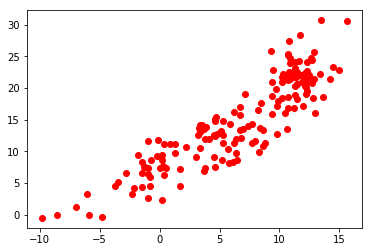

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib nbagg

xp = []
yp = []

for x in mList:
    if 'VICTORIA' in x['Station Name']:
        for y in x['Data']:
            if y['Date/Time'].date() <= dt.date(2013, 12, 31) and \
               y['Date/Time'].date() >= dt.date(2013,  1,  1):
                xp.append(y['Min Temp (°C)'])
                yp.append(y['Max Temp (°C)'])

plt.plot( xp, yp, 'ro' )

### Criticisms:

* Diagram could be larger. 
* Red dots kind of blur together. 
* Legend, axis labels. 
* Aspect ratio?


Text(0.5,1,'Min vs. Max temp for Victoria')

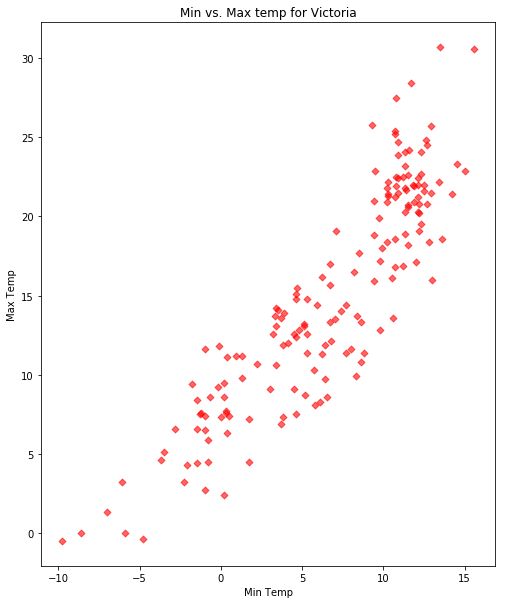

In [3]:
xw = max(xp)-min(xp)
yw = max(yp)-min(yp)
scl = max([xw, yw])
plt.figure(figsize=(10*xw/scl,10*yw/scl))

plt.scatter( xp, yp, c='red', s=24, alpha=0.6, marker='D' )
plt.xlabel('Min Temp')
plt.ylabel('Max Temp')
plt.title("Min vs. Max temp for Victoria")

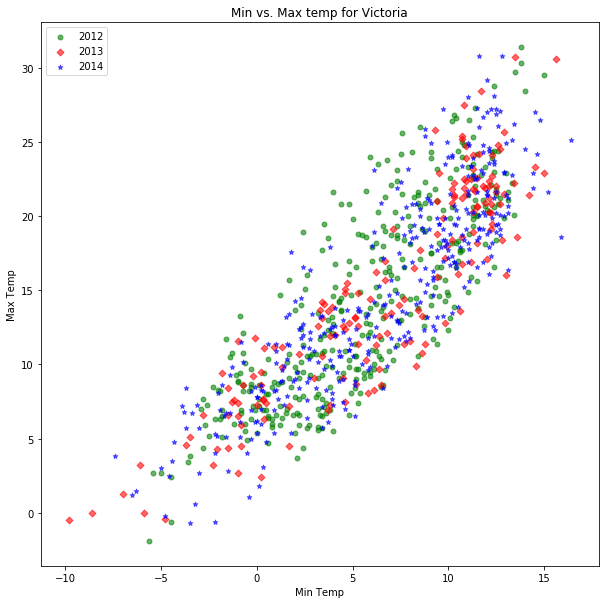

In [4]:
## let's do the same but with multiple years in multiple colours.
xpl = dict()
ypl = dict()
years = [2012, 2013, 2014]
colours = { 2012: 'green', 2013: 'red', 2014: 'blue'}
marks = { 2012: 'o', 2013: 'D', 2014: '*'}

for yr in years:
    xp = []
    yp = []
    for x in mList:
        if 'VICTORIA' in x['Station Name']:
            for y in x['Data']:
                if y['Date/Time'].date() <= dt.date(yr, 12, 31) and \
                   y['Date/Time'].date() >= dt.date(yr,  1,  1):
                    xp.append(y['Min Temp (°C)'])
                    yp.append(y['Max Temp (°C)'])
    xpl[yr] = xp
    ypl[yr] = yp

xw = max(xp)-min(xp)
yw = max(yp)-min(yp)
scl = max([xw, yw])

xw = dict()
yw = dict()
for yr in years:
    xw[yr] = max(xpl[yr]) - min(xpl[yr])
    yw[yr] = max(xpl[yr]) - min(ypl[yr])
    
## max and min works for more than just lists, you can use
## arbitrary iterables as well with this notation. keys on
## left, function of keys on right.
xW = max(xw.keys(), key=(lambda k: xw[k]))
yW = max(yw.keys(), key=(lambda k: yw[k]))
scl = max(xW, yW)

plt.figure(figsize=(10*xW/scl,10*yW/scl))

for yr in years:
    plt.scatter( xpl[yr], ypl[yr], c=colours[yr], s=24, alpha=0.6, marker=marks[yr],\
               label = str(yr) )
    
plt.xlabel('Min Temp')
plt.ylabel('Max Temp')
plt.title("Min vs. Max temp for Victoria")
plt.legend(loc='upper left')

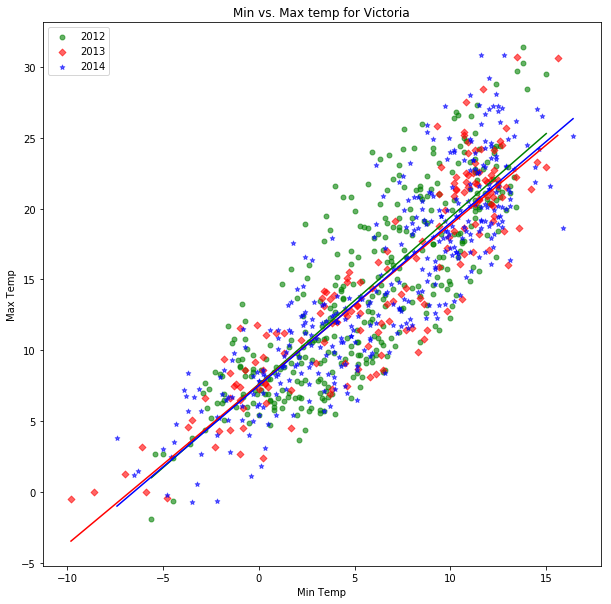

In [5]:
import numpy as np

cl = dict()
for yr in years:
    A = np.matrix([[1.0, x] for x in xpl[yr]]).T
    y = np.matrix([y for y in ypl[yr]]).T
    C = np.linalg.inv(A*A.T)*A*y
    cl[yr] = (C[0,0], C[1,0])
#print(cl)

plt.figure(figsize=(10*xW/scl,10*yW/scl))

for yr in years:
    plt.scatter( xpl[yr], ypl[yr], c=colours[yr], s=24, alpha=0.6, marker=marks[yr],\
               label = str(yr) )
    plt.plot([min(xpl[yr]), max(xpl[yr])], \
        [cl[yr][0]+cl[yr][1]*min(xpl[yr]), cl[yr][0]+cl[yr][1]*max(xpl[yr])],\
             color=colours[yr])
    
plt.xlabel('Min Temp')
plt.ylabel('Max Temp')
plt.title("Min vs. Max temp for Victoria")
plt.legend(loc='upper left')

In [6]:
## A histogram example. 
## 
## let's take a sampling of points in the plane and draw a histogram
##  of the projection of the data onto a given axis. 

## multi-variable normal. centre, covariance matrix, num pts.
data = np.random.multivariate_normal([0,0],[[1,0],[0,2]],  
                                     800)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'histogram of data projected\n onto the 6x+1y=0 line')

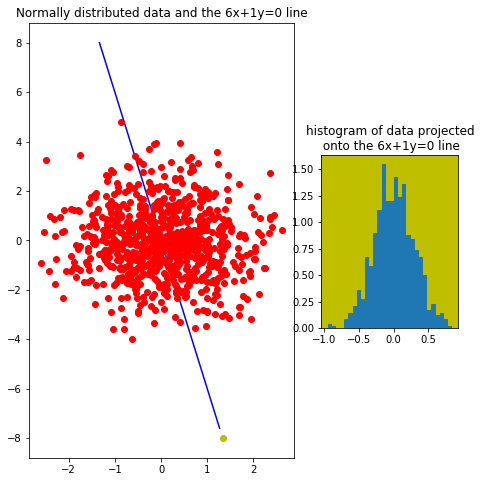

In [7]:
fig,ax = plt.subplots()
## this helps me force a 1:1 aspect ratio in the figure.
xw = np.max(data.T[0]) - np.min(data.T[0])
yw = np.max(data.T[1]) - np.min(data.T[1])
mw = max(xw,yw)
xw = 8*xw/mw ## the largest dimension is 10. 
yw = 8*yw/mw
fig.set_size_inches(xw,yw)

## let's project onto the line with equation
##  ax+by = 0
a = 6
b = 1
## make the line go to roughly the bounding box.
bounds = []
if b!=0: bounds.append(abs(xw/b))
if a!=0: bounds.append(abs(yw/a))
M = min(bounds)
plt.plot(b*np.arange(-M,M, 0.1), -a*np.arange(-M,M, 0.1), 'b-')
plt.plot([b*M], [-a*M], 'yo')

## data plot
plt.plot(data.T[0], data.T[1], 'ro')
plt.title("Normally distributed data and the "+str(a)+"x+"+str(b)+"y=0 line")
## histogram
nPV = 1/np.sqrt(b**2+a**2)
projDat = [nPV*(data[i,0]*b-data[i,1]) for i in range(data.shape[0])]
ax1=plt.axes([0.98,0.35,0.4,0.3], axisbg='y')
## here is the call to make the histogram
##  it takes a list of real numbers. 
plt.hist(projDat, normed=True, bins=30)
plt.title("histogram of data projected\n onto the "+str(a)+"x+"+str(b)+"y=0 line")

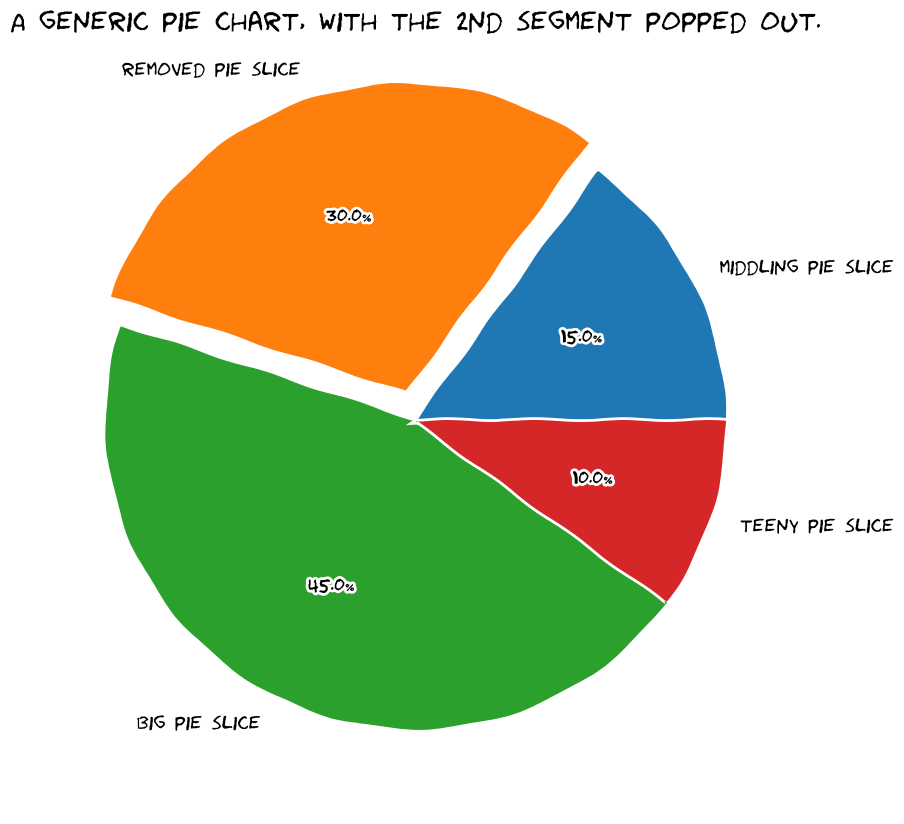

In [11]:
plt.rc('text', usetex=False)

with plt.xkcd(): ## this enables the xkcd style.
    
    fig=plt.figure()
    fig.set_size_inches(10,10) 
    
    fracs = [15,30,45,10]
    pushOut = (0,0.1,0,0) ##
    labL = 'middling pie slice', 'removed pie slice', 'big pie slice', 'teeny pie slice'
    
    ## explode is the push-out parameter.  labels are the text around the
    ## circumference.  autopct puts the percentage in the pie slices. 
    ## shadow adds a bit of depth to the image.
    plt.pie(fracs, explode=pushOut, labels=labL, autopct='%1.1f%%', shadow=False)
    ## shadow=True / False
    plt.title('A generic pie chart, with the 2nd segment popped out.', fontsize=20)
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1.05,'graph of $r=\\log(\\theta)$\non the interval $\\theta \\in [0,60\\pi]$')

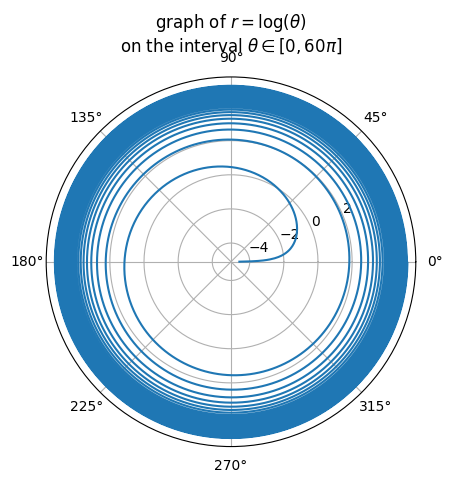

In [13]:
## polar coordinates
plt.rcdefaults()
plt.close()

theta = np.arange(0, 30*2*np.pi, 0.01)
r = np.log(theta)

ax = plt.subplot(projection='polar')
fig = plt.gcf()
#fig.set_size_inches(4,4)

plt.plot(theta, r)
plt.title("graph of $r=\\log(\\theta)$\n"
          "on the interval $\\theta \in [0,60\pi]$", fontsize=12)

In [14]:
import tqdm
import time as ti

## gui based progress monitor
for i in tqdm.tqdm(range(6)):
    ti.sleep(1)    

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]
